# 特征工程

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

### 读取数据集

In [2]:
data_train =pd.read_csv('./train_2.csv')
data_testA = pd.read_csv('./testA_2.csv')

### 1.数据预处理部分

查询数据中的对象特征和数值特征

In [3]:
numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(data_train.columns)))
label = 'isDefault'
numerical_fea.remove(label)

查看缺失值的情况

In [4]:
data_train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           1
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  1
regionCode                0
dti                     239
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies      405
revolBal                  0
revolUtil               531
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     1
policyCode                0
n0                    40270
n1                    40270
n2                    40270
n3                  

使用平均数、众数对train数据集空值进行填充

In [5]:
data_train[numerical_fea] = data_train[numerical_fea].fillna(data_train[numerical_fea].median())
data_train[category_fea] = data_train[category_fea].fillna(data_train[category_fea].mode())

查看处理后缺失值情况

In [7]:
data_train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           0
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  0
regionCode                0
dti                       0
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies        0
revolBal                  0
revolUtil                 0
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     0
policyCode                0
n0                        0
n1                        0
n2                        0
n3                  

使用平均数、众数对testA数据集空值进行填充

In [8]:
data_testA[numerical_fea] = data_testA[numerical_fea].fillna(data_train[numerical_fea].median())
data_testA[category_fea] = data_testA[category_fea].fillna(data_train[category_fea].mode())

In [9]:
data_testA.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           0
employmentLength      11742
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
purpose                   0
postCode                  0
regionCode                0
dti                       0
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies        0
revolBal                  0
revolUtil                 0
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     0
policyCode                0
n0                        0
n1                        0
n2                        0
n3                        0
n4                  

时间格式处理

In [10]:
for data in [data_train, data_testA]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
    data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days

In [11]:
data_train['employmentLength'].value_counts(dropna=False).sort_index()

1 year        52489
10+ years    262753
2 years       72358
3 years       64152
4 years       47985
5 years       50102
6 years       37254
7 years       35407
8 years       36192
9 years       30272
< 1 year      64237
NaN           46799
Name: employmentLength, dtype: int64

对象类型特征转换

In [12]:
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
for data in [data_train, data_testA]:
    data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
    data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)
    
data['employmentLength'].value_counts(dropna=False).sort_index()

 0.0     15989
 1.0     13182
 2.0     18207
 3.0     16011
 4.0     11833
 5.0     12543
 6.0      9328
 7.0      8823
 8.0      8976
 9.0      7594
 10.0    65772
NaN      11742
Name: employmentLength, dtype: int64

对earliesCreditLine进行预处理

In [13]:
for data in [data_train, data_testA]:
    data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda s: int(s[-4:]))

将表示等级的类别特征转换为数值型特征

In [15]:
for data in [data_train, data_testA]:
    data['grade'] = data['grade'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})

### 2.异常值处理

使用均方差进行异常值检测，并分析异常值与目标变量的关系

In [16]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data

data_train = data_train.copy()
for fea in numerical_fea:
    data_train = find_outliers_by_3segama(data_train,fea)
    print(data_train[fea+'_outliers'].value_counts())
    print(data_train.groupby(fea+'_outliers')['isDefault'].sum())
    print('*'*10)

正常值    800000
Name: id_outliers, dtype: int64
id_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    800000
Name: loanAmnt_outliers, dtype: int64
loanAmnt_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    800000
Name: term_outliers, dtype: int64
term_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    794259
异常值      5741
Name: interestRate_outliers, dtype: int64
interestRate_outliers
异常值      2916
正常值    156694
Name: isDefault, dtype: int64
**********
正常值    792046
异常值      7954
Name: installment_outliers, dtype: int64
installment_outliers
异常值      2152
正常值    157458
Name: isDefault, dtype: int64
**********
正常值    800000
Name: employmentTitle_outliers, dtype: int64
employmentTitle_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    799701
异常值       299
Name: homeOwnership_outliers, dtype: int64
homeOwnership_outliers
异常值        62
正常值    159548
Name: isDefault, dtype: int64
**********
正常值    793973
异常值      

删除检测到的异常值

In [17]:
for fea in numerical_fea:
    data_train = data_train[data_train[fea+'_outliers']=='正常值']
    data_train = data_train.reset_index(drop=True) 

### 3.数据分箱

分位数分箱

In [18]:
data['loanAmnt_bin1'] = pd.qcut(data['loanAmnt'], 10, labels=False)

对数函数

In [19]:
data['loanAmnt_bin2'] = np.floor(np.log10(data['loanAmnt']))

除法映射

In [20]:
data['loanAmnt_bin1'] = np.floor_divide(data['loanAmnt'], 1000)

### 4.特征交互

In [21]:
for col in ['grade', 'subGrade']:
    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()

    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)
    data_testA[col + '_target_mean'] = data_testA[col].map(temp_dict)

for df in [data_train, data_testA]:
    for item in ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13','n14']:
        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')
        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')

### 5.计算特征相关性

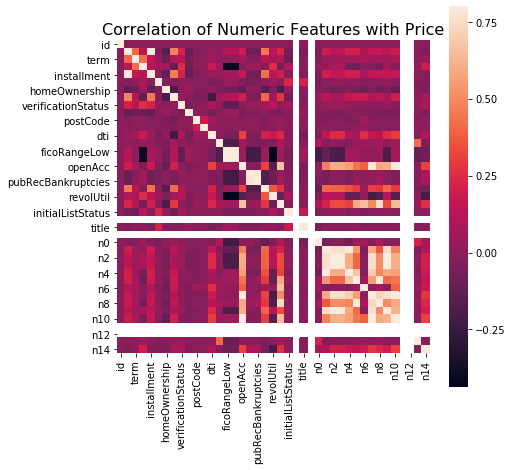

In [22]:
x_train = data_train.drop(['isDefault','id'], axis=1)
data_corr = x_train.corrwith(data_train.isDefault)
result = pd.DataFrame(columns=['features', 'corr'])
result['features'] = data_corr.index
result['corr'] = data_corr.values
data_numeric = data_train[numerical_fea]
correlation = data_numeric.corr()

f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)

In [24]:
# 输出处理好的数据集
features = [f for f in data_train.columns if f not in ['id', 'issueDate', 'isDefault'] and '_outliers' not in f]
x_train = data_train[features]
x_test = data_testA[features]
y_train = data_train['isDefault']


x_train['sample']='train'
x_test['sample']='test'
data_for_model=pd.concat([x_train,x_test],axis=0)
data_for_model.to_csv('data_for_model.csv',index=False)
y_train.to_csv('label_for_model.csv',index=False)